In [1]:
import sys
sys.path.append('..')

In [2]:
import time
from gerumo.data.dataset import describe_dataset
from gerumo.data.generators import build_generator
from gerumo.utils.engine import (
    setup_cfg, setup_environment, setup_experiment, setup_model,
    build_dataset, build_callbacks, build_metrics, build_optimizer, build_loss
)
from gerumo.models.base import build_model
from gerumo.visualization.metrics import training_history


class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
args = dotdict()

## Select configuration

In [3]:
args['config_file'] = '/home/ir-riqu1/gerumo2/config/rf_classification_debug.yml'
#args['config_file'] = '/home/ir-riqu1/gerumo2/config/cnn_classification.yml'
args['opts'] = []

## Setup

In [4]:
cfg = setup_cfg(args)
output_dir = setup_experiment(cfg)
logger = setup_environment(cfg)

## Load Datasets

In [5]:
train_dataset = build_dataset(cfg, 'train')
describe_dataset(train_dataset, logger,
                save_to=output_dir / "train_description.txt")
validation_dataset = build_dataset(cfg, 'validation')
describe_dataset(validation_dataset, logger,
                save_to=output_dir / "validation_description.txt")

[GERUMO]: INFO     files: 20
[GERUMO]: INFO     events: 152742
[GERUMO]: INFO     observations: 1125729
[GERUMO]: INFO     obsevation by telescopes
[GERUMO]: INFO     NectarCam    393562
FlashCam     359974
CHEC         320404
LSTCam        51789
Name: camera_type, dtype: int64
[GERUMO]: INFO     files: 20
[GERUMO]: INFO     events: 46617
[GERUMO]: INFO     observations: 118609
[GERUMO]: INFO     obsevation by telescopes
[GERUMO]: INFO     CHEC         52759
NectarCam    33736
FlashCam     27240
LSTCam        4874
Name: camera_type, dtype: int64


## Build generators

In [6]:
train_generator = build_generator(cfg, train_dataset)
validation_generator = build_generator(cfg, validation_dataset)

In [7]:
print(len(train_generator))
print(len(validation_generator))

1251
206


In [8]:
n_estimators = 100 # integer
criterion = 'gini' # 'gini' or 'entropy'
max_depth = None # null or integer
min_samples_split = 2 # integer or float
min_samples_leaf = 1 # integer or float
min_weight_fraction_leaf = 0.0 # float
max_features = 3 # 'auto', 'sqrt', 'log2', integer or float
max_leaf_nodes = None # null or integer
min_impurity_decrease = 0.0 # float
bootstrap = False # True or False
oob_score= False # True or False
n_jobs = -1 # null or integer
random_state = 42 # null or integer or RandomState
verbose = 0 # integer
warm_start = False # 'True' or 'False'
class_weight = None # 'balanced', 'balanced_subsample', null, dict or list of dicts
ccp_alpha = 0.0 # non-negative float
max_samples = None # null, integer or float

In [9]:
n_estimators = 100
criterion = 'gini'
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_features = 3
min_impurity_decrease = 0.0
random_state = 42
bootstrap = True
max_samples = 0.7
verbose = 0
n_jobs = -1
warm_start = True
oob_score = True
max_samples = None # null, integer or float

## Build model

In [10]:
#input_shape = train_generator.get_input_shape()
#model = build_model(cfg, input_shape)
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(
    n_estimators = n_estimators,
    criterion = criterion,
    max_depth = max_depth,
    min_samples_split = min_samples_split,
    min_samples_leaf=min_samples_leaf,
    min_weight_fraction_leaf = min_weight_fraction_leaf,
    max_features = max_features,
    min_impurity_decrease = min_impurity_decrease,
    random_state = random_state,
    bootstrap = bootstrap,
    verbose = verbose,
    n_jobs = n_jobs,
    warm_start = warm_start,
    oob_score = oob_score,
    ccp_alpha = ccp_alpha,
    max_samples = max_samples)
    

## Build training tools

In [11]:
#callbacks = build_callbacks(cfg)
#metrics = build_metrics(cfg)
#optimizer = build_optimizer(cfg)
#loss = build_loss(cfg)

## Compile model

In [12]:
#model = setup_model(
#    model, train_generator, optimizer, loss, metrics
#)

## Start training

In [13]:
train_generator.fit_mode()
validation_generator.fit_mode()
score=[]
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
start_time = time.time()
from tqdm import tqdm
pbar = tqdm(train_generator, total=len(train_generator)) 
for i, (batch_inputs, batch_outputs) in enumerate(pbar):
    labels=enc.fit_transform(batch_outputs).toarray()
    #batch_inputs_norm=sc.fit_transform(batch_inputs)
    rf.fit(batch_inputs, labels)
    rf.n_estimators+=1
    score.append(rf.oob_score_)
    
    
    
training_time = (time.time() - start_time)/60.0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1251/1251 [07:27<00:00,  2.80it/s]


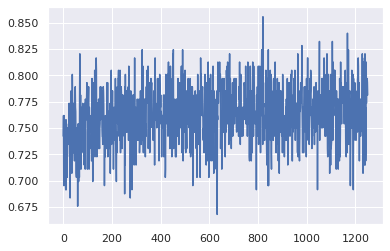

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.array(score))

In [15]:
logger.info(f"Training time: {training_time:.3f} [min]")

[GERUMO]: INFO     Training time: 7.455 [min]


# Testing

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score

In [17]:
pbar = tqdm(train_generator, total=len(train_generator))
predictions_tr=[]
true_tr=[]

for i, (batch_inputs, batch_outputs) in enumerate(pbar):
    labels_tr=enc.fit_transform(batch_outputs).toarray()
    #batch_inputs_norm=sc.fit_transform(batch_inputs)
    predictions_tr.extend(rf.predict(batch_inputs))
    true_tr.extend(labels_tr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1251/1251 [07:51<00:00,  2.65it/s]


In [18]:
pbar = tqdm(validation_generator, total=len(validation_generator))
predictions=[]
true=[]
true_batches=[]
start_time = time.time()
for i, (batch_inputs, batch_outputs) in enumerate(pbar):
    true_batches.extend(batch_outputs)
    labels=enc.fit_transform(batch_outputs).toarray()
    #batch_inputs_norm=sc.fit_transform(batch_inputs)
    pre = rf.predict(batch_inputs)
    predictions.extend(pre)
    #print(accuracy_score(labels,np.array(pre)))
    true.extend(labels)
    
training_time = (time.time() - start_time)/60.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [01:17<00:00,  2.65it/s]


In [19]:
logger.info(f"Testing time: {training_time:.3f} [min]")

[GERUMO]: INFO     Testing time: 1.295 [min]


In [20]:
import numpy as np
from sklearn.metrics import accuracy_score
acc=accuracy_score(np.array(true),np.array(predictions))
acc_tr=accuracy_score(np.array(true_tr),np.array(predictions_tr))
print('trained on: {}'.format(cfg.DATASETS.TRAIN.EVENTS[58:]))
print('tested on: {}'.format(cfg.DATASETS.VALIDATION.EVENTS[58:]))
print('{0} Testing Accuracy : {1:.4f}'.format(cfg.MODEL.TELESCOPES[0],acc))
print('{0} Training Accuracy : {1:.4f}'.format(cfg.MODEL.TELESCOPES[0],acc_tr))

trained on: output_tiny_splitted/train_events.parquet
tested on: output_tiny_splitted/validation_events.parquet
SST Testing Accuracy : 0.7608
SST Training Accuracy : 0.7678


In [21]:
np.array(predictions).sum(axis=0)

array([19831., 32869.])

In [22]:
np.array(true).sum(axis=0).max()/np.array(true).sum(axis=0).sum()

0.5516535194174758

# Random Forest 2nd Try

In [41]:
n_estimators = 100 # integer
criterion = 'gini' # 'gini' or 'entropy'
max_depth = None # null or integer
min_samples_split = 2 # integer or float
min_samples_leaf = 1 # integer or float
min_weight_fraction_leaf = 0.0 # float
max_features = 3 # 'auto', 'sqrt', 'log2', integer or float
max_leaf_nodes = None # null or integer
min_impurity_decrease = 0.0 # float
bootstrap = True # True or False
oob_score= True # True or False
n_jobs = -1 # null or integer
random_state = 42 # null or integer or RandomState
verbose = 1 # integer
warm_start = True # 'True' or 'False'
class_weight = None # 'balanced', 'balanced_subsample', null, dict or list of dicts
ccp_alpha = 0.0 # non-negative float
max_samples = None # null, integer or float

In [42]:
rf2 = RandomForestClassifier(
    n_estimators = n_estimators,
    criterion = criterion,
    max_depth = max_depth,
    min_samples_split = min_samples_split,
    min_samples_leaf=min_samples_leaf,
    min_weight_fraction_leaf = min_weight_fraction_leaf,
    max_features = max_features,
    min_impurity_decrease = min_impurity_decrease,
    random_state = random_state,
    bootstrap = bootstrap,
    verbose = verbose,
    n_jobs = n_jobs,
    warm_start = warm_start,
    oob_score = oob_score,
    ccp_alpha = ccp_alpha,
    max_samples = max_samples)

In [43]:
train_generator = build_generator(cfg, train_dataset)
validation_generator = build_generator(cfg, validation_dataset)

In [44]:
train_generator.fit_mode()
validation_generator.fit_mode()

In [45]:
features=[]
output=[]
for batch_inputs, batch_outputs in train_generator:
    features.extend(batch_inputs)
    labels=enc.fit_transform(batch_outputs).toarray()
    output.extend(labels)
    

In [46]:
test_features=[]
test_output=[]
for batch_inputs, batch_outputs in validation_generator:
    test_features.extend(batch_inputs)
    test_labels=enc.fit_transform(batch_outputs).toarray()
    test_output.extend(test_labels)

In [47]:
rf2.fit(np.array(features),np.array(output))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestClassifier(max_features=3, n_jobs=-1, oob_score=True,
                       random_state=42, verbose=1, warm_start=True)

In [48]:
pred=rf2.predict(np.array(test_features))

[Parallel(n_jobs=76)]: Using backend ThreadingBackend with 76 concurrent workers.
[Parallel(n_jobs=76)]: Done  50 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=76)]: Done 100 out of 100 | elapsed:    0.0s finished


In [49]:
import numpy as np
from sklearn.metrics import accuracy_score
acc=accuracy_score(np.array(test_output),np.array(pred))

In [53]:
print(acc)

0.5565378289473685


In [51]:
rf2.oob_score_

0.7037631497524752

In [52]:
np.array(test_output).sum(axis=0).max()/np.array(test_output).sum(axis=0).sum()

0.5733963815789473

In [54]:
from tensorflow.keras.metrics import CategoricalAccuracy
m = CategoricalAccuracy()
m.update_state(np.array(pred), np.array(test_output))
m.result().numpy()

2022-01-04 20:46:19.560756: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-04 20:46:19.560798: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-q-1): /proc/driver/nvidia/version does not exist
2022-01-04 20:46:19.603451: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.56702304